# Run Sandwich Attacks on Swaps from the Public Mempool

In [3]:
%load_ext autoreload
%autoreload 2

In [31]:
import os
import sys
import math

current_path = sys.path[0]
sys.path.append(
    current_path[: current_path.find("defi-measurement")]
    + "liquidity-distribution-history"
)

sys.path.append("..")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from datetime import datetime, timezone


# Set display options
pd.set_option("display.max_colwidth", None)  # Display entire cell content
pd.set_option("display.max_rows", 50)  # Display all rows
pd.set_option("display.max_columns", None)  # Display all columns


from dotenv import load_dotenv
from pool_state import v3Pool
from sqlalchemy import create_engine
from tqdm import tqdm

load_dotenv(override=True)
# from experiments.random_permutations import load_pool

from experiments.preload_pool_cache import load_pool_from_blob
from experiments.calculate_simple_sandwich import (
    get_data,
    SwapData,
    single_sandwich_mev,
    max_frontrun,
    auto_sandwich_mev,
)


from decimal import getcontext

getcontext().prec = 100  # Set the precision high enough for our purposes


# Read in the environment variables
postgres_uri_mp = os.environ["POSTGRESQL_URI_MP"]
postgres_uri_us = os.environ["POSTGRESQL_URI_US"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]

## Get the Data

### Populate the swap data we have with the block number that the swap appeared in

In [42]:
df = get_data()

df.head()

amountIn  \
pool                                       block_number                
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0     3200000000   
                                           17552242.0      303798589   
                                           17552250.0    16102020684   
                                           17552252.0     6543850000   
                                           17552278.0      150000000   

                                                                amountOutMin  \
pool                                       block_number                        
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    1608133671221393483   
                                           17552242.0     160355281886090203   
                                           17552250.0    8532306101844837653   
                                           17552252.0    3467552154643320542   
                                           17552278.0      79798648054443290   

                                                                                             token0  \
pool                                       block_number                                               
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552242.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552250.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552252.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552278.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   

                                                         fee  \
pool                                       block_number        
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    500   
                                           17552242.0    500   
                                           17552250.0    500   
                                           17552252.0    500   
                                           17552278.0    500   

                                                                                             token1  \
pool                                       block_number                                               
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552242.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552250.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552252.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552278.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                                                                                                       hash  \
pool                                       block_number                                                                       
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    0xcccbb87fc3e5e2b7851adc2140f46603c39eebef648048d59904987f47a9aa50   
                                           17552242.0    0x4c1da0dcc8367691658daa4bf50af22df275e8898975edfb96c65625da07098d   
                                           17552250.0    0x94f9a95e35ef12f68ce0b4aa1a40a15e8f72472f5af549fc90dc884909db6522   
                                           17552252.0    0xc708f2903a47f281da6eaa12ea3e35f5c396a2567e3f7478058c1102a11f2bd4   
                                           17552278.0    0x3aebe0e7c4c49d9e98f394e4c5141b731ebf63c73a74b388bcb5258c61440fe3   

                                                                              first_seen  
pool                                       block_number                                   
0x88e6a0c2ddd26feeb64f039a2c4

## Get a pool and do some initial testing

In [48]:
swap_data = df[df.hash == '0x503ff2a5421b7a3e9594051eb933ad5ea01a9ccc0d76a41b5fc2df945af2a7f2']

swap = SwapData(**swap_data.reset_index().to_dict('records')[0]) # type: ignore

swap

SwapData(pool='0x78d4e81fc84a1ce367e90936e49a74a9052137e8', block_number=17578916.0, amountIn='10000000000000000000', amountOutMin='466622823911182083', token0='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', fee='10000', token1='0x2890df158d76e584877a1d17a85fea3aeeb85aa6', hash='0x503ff2a5421b7a3e9594051eb933ad5ea01a9ccc0d76a41b5fc2df945af2a7f2', first_seen=Timestamp('2023-06-28 16:09:49.897000+0000', tz='UTC'))

In [49]:
pool = load_pool_from_blob(
    str(swap_data.index.get_level_values(0)[0]),
    postgres_uri_us,
    azure_storage_uri,
    "uniswap-v3-pool-cache",
    verbose=True,
    invalidate_before_date=datetime(2023, 8, 16, tzinfo=timezone.utc),
)

Loading pool from Azure blob storage cache


In [50]:
assert pool

max_frontrun(
    pool,
    swap,
    verbose=True,
)

0: Trying 1000000.0
1: Trying 2000000.0
2: Trying 4000000.0
3: Trying 8000000.0
4: Trying 16000000.0
5: Trying 32000000.0
6: Trying 64000000.0
7: Trying 128000000.0
8: Trying 256000000.0
9: Trying 512000000.0
10: Trying 1024000000.0
11: Trying 2048000000.0
12: Trying 4096000000.0
13: Trying 8192000000.0
14: Trying 16384000000.0
15: Trying 32768000000.0
16: Trying 65536000000.0
17: Trying 131072000000.0
18: Trying 262144000000.0
19: Trying 524288000000.0
20: Trying 1048576000000.0
21: Trying 2097152000000.0
22: Trying 4194304000000.0
23: Trying 8388608000000.0
24: Trying 16777216000000.0
25: Trying 33554432000000.0
26: Trying 67108864000000.0
27: Trying 134217728000000.0
28: Trying 268435456000000.0
29: Trying 536870912000000.0
30: Trying 1073741824000000.0
31: Trying 2147483648000000.0
32: Trying 4294967296000000.0
33: Trying 8589934592000000.0
34: Trying 1.7179869184e+16
35: Trying 3.4359738368e+16
36: Trying 6.8719476736e+16
37: Trying 1.37438953472e+17
38: Trying 2.74877906944e+17
0

2.72994664448e+17

In [54]:
assert pool is not None

profit, gas, prices = single_sandwich_mev(
    pool,
    swap,
    int(2.72994664448e+17),
    pool_fee=True,
)

print(f"Profit: {profit / 1e18}")
print(f"Gas: {gas}")
print(f"Prices: {prices}")

Profit: 0.003185129981081248
Gas: 0.006719305386569982
Prices: (4.56768883595478, 4.569668914667892, 4.642682234572798, 4.64065881939532)


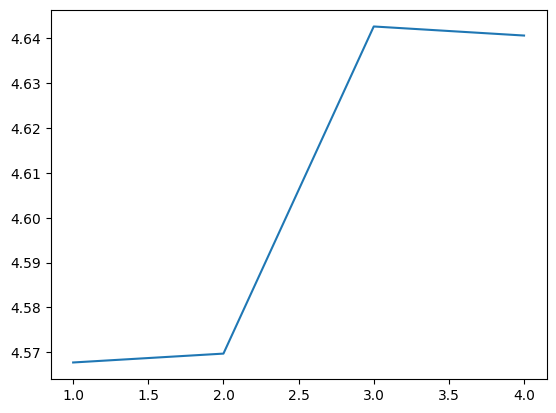

In [53]:
plt.plot([1,2,3,4], prices);

In [40]:
assert pool is not None

auto_sandwich_mev(
    pool,
    swap,
    start=1e12,
    factor=10,
    pool_fee=True,
    verbose=True,
)

0: Trying 1000000.0
1: Trying 10000000.0
2: Trying 100000000.0
3: Trying 1000000000.0
4: Trying 10000000000.0
5: Trying 100000000000.0
6: Trying 1000000000000.0
7: Trying 10000000000000.0
0: Trying 1000000000000.0 - 10000000000000.0
1: Trying 5500000000000.0 - 10000000000000.0
2: Trying 5500000000000.0 - 7750000000000.0
3: Trying 5500000000000.0 - 6625000000000.0
4: Trying 6062500000000.0 - 6625000000000.0
5: Trying 6343750000000.0 - 6625000000000.0
6: Trying 6343750000000.0 - 6484375000000.0
7: Trying 6343750000000.0 - 6414062500000.0
8: Trying 6343750000000.0 - 6378906250000.0
9: Trying 6343750000000.0 - 6361328125000.0
10: Trying 6352539062500.0 - 6361328125000.0
11: Trying 6352539062500.0 - 6356933593750.0
12: Trying 6352539062500.0 - 6354736328125.0
13: Trying 6352539062500.0 - 6353637695312.0
14: Trying 6352539062500.0 - 6353088378906.0
15: Trying 6352813720703.0 - 6353088378906.0
16: Trying 6352951049804.0 - 6353088378906.0
17: Trying 6353019714355.0 - 6353088378906.0
18: Trying

AutoSandwichResult(profit=-6284193032.0, gas_fee=0.007010483569918752, frontrun_input=6353019714355.0, price_baseline=4.3577930944809406e-05, price_frontrun=4.4178991727856794e-05, price_user=4.417908996981208e-05, price_backrun=4.35782501103994e-05)

## Inspect the sandwiches created

In [73]:
engine = create_engine(postgres_uri_mp)

sw = pd.read_sql_query(
    """
    SELECT * FROM simple_sandwiches
    """,
    engine,
)

sw.shape

(1335, 17)

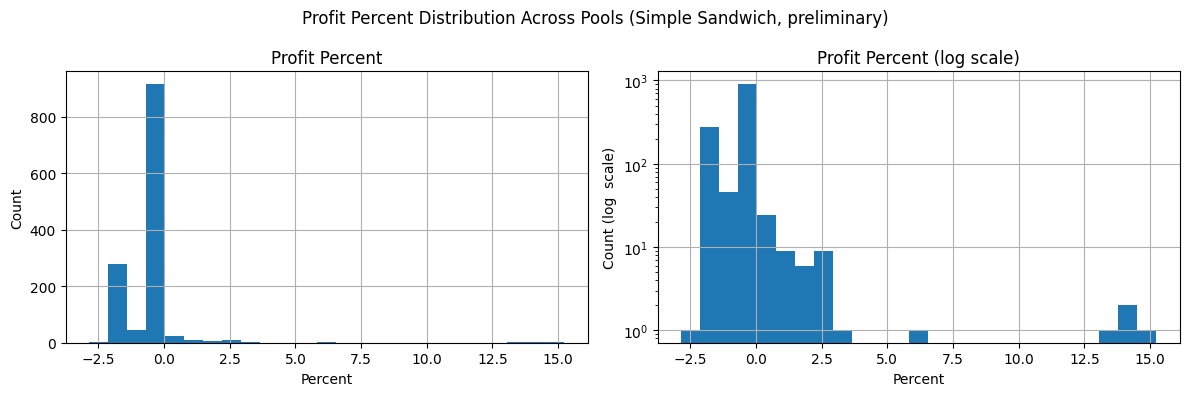

In [72]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

(sw.profit_percent * 100).hist(bins=25, ax=ax1)
(sw.profit_percent * 100).hist(bins=25, ax=ax2);

# Make log y axis
ax2.set_yscale('log')

# Set titles
ax1.set_title('Profit Percent')
ax2.set_title('Profit Percent (log scale)')

# Set x labels
ax1.set_xlabel('Percent')
ax2.set_xlabel('Percent')

# Set y labels
ax1.set_ylabel('Count')
ax2.set_ylabel('Count (log  scale)');

# Subtitle
plt.suptitle('Profit Percent Distribution Across Pools (Simple Sandwich, preliminary)');

plt.tight_layout()

## Spurious calculations

In [ ]:
# Given 17 seconds per sandwich, how many sandwiches can you make in a night?
hours_per_night = 8
seconds_per_sandwich = 17
cpus = 1

hours_per_night * 60 * 60 / seconds_per_sandwich * cpus

1694.1176470588234